In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, roc_auc_score, mean_squared_error, mean_absolute_error

In [2]:
!pip install catboost

     ---------------------------------------- 0.0/47.0 kB ? eta -:--:--
     -------- ------------------------------- 10.2/47.0 kB ? eta -:--:--
     ---------------- --------------------- 20.5/47.0 kB 222.6 kB/s eta 0:00:01
     --------------------------------- ---- 41.0/47.0 kB 281.8 kB/s eta 0:00:01
     --------------------------------- ---- 41.0/47.0 kB 281.8 kB/s eta 0:00:01
     -------------------------------------- 47.0/47.0 kB 181.3 kB/s eta 0:00:00
   ---------------------------------------- 0.0/101.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.0 MB ? eta -:--:--
   -----------------------------------


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
X = pd.read_csv("./training_set_features.csv")
print("the X's shape: ", X.shape)
X.head()

the X's shape:  (26707, 36)


,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [4]:
y = pd.read_csv('./training_set_labels.csv')
y.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0


In [5]:
def plot_missing_values(dataframe):
    missing_values = dataframe.isnull().sum()
    missing_values = missing_values[missing_values > 0]  # Select features with missing values

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(missing_values.index, missing_values.values)
    plt.xlabel('Features')
    plt.ylabel('Count of Missing Values')
    plt.title('Missing Values in X')
    plt.xticks(rotation=90)
    plt.show()

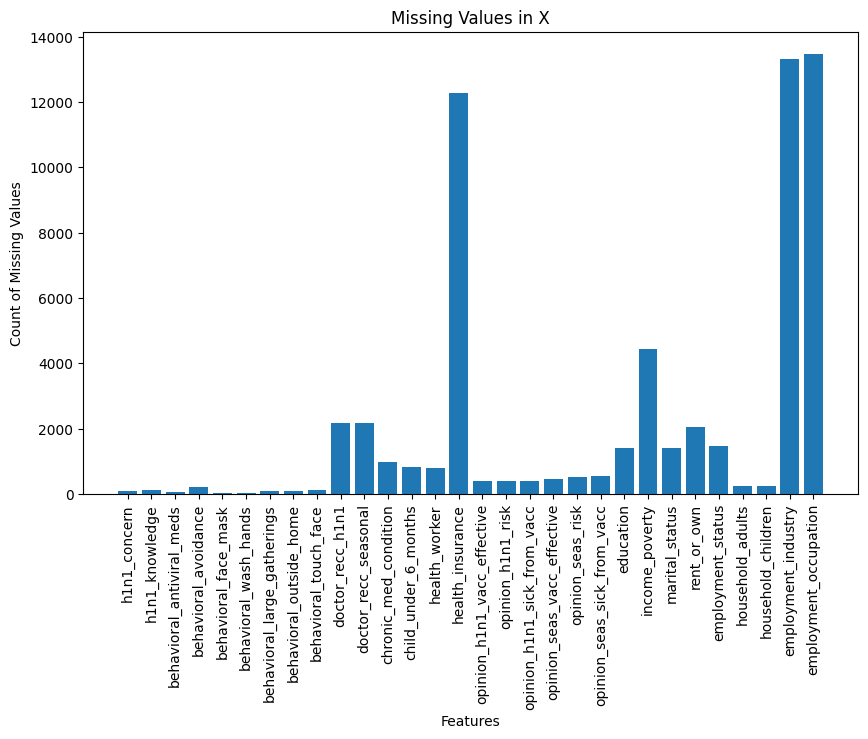

In [6]:
plot_missing_values(X)

In [7]:
def plot_unique_values(dataframe):
    # Iterate over each feature
    for column in dataframe.columns:
        unique_values = dataframe[column].nunique()
        missing_values = dataframe[column].isnull().sum()  # Count missing values
        
        # If the feature has more than ten unique values, plot the ten most frequent values
        if unique_values > 10:
            most_frequent_values = dataframe[column].value_counts().nlargest(10)
            plt.figure(figsize=(8, 4))
            sns.countplot(x=column, data=dataframe, order=most_frequent_values.index, hue=column, palette='viridis', legend=False)
            plt.title(f"Top 10 Most Frequent Values - {column}")
            plt.xlabel(column)
            plt.ylabel("Count")
            plt.xticks(rotation=45)
            plt.show()
            print(f"Only the top 10 most frequent values are plotted out of {unique_values} unique values for {column}.")
        else:
            plt.figure(figsize=(8, 4))
            sns.countplot(x=column, data=dataframe, order=dataframe[column].value_counts().index, palette='viridis', hue=column, legend=False)
            plt.title(f"Unique Values - {column}")
            plt.xlabel(column)
            plt.ylabel("Count")
            plt.xticks(rotation=45)
            plt.show()
            print(f"All unique values ({unique_values}) are plotted for {column}.")
        
        print(f"Missing values in {column}: {missing_values}\n")

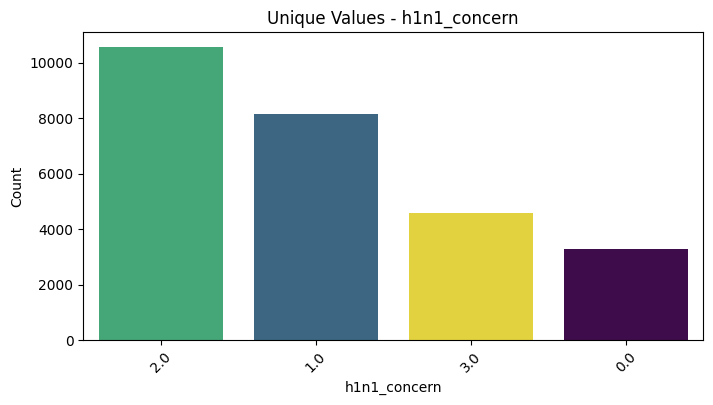

All unique values (4) are plotted for h1n1_concern.
Missing values in h1n1_concern: 92



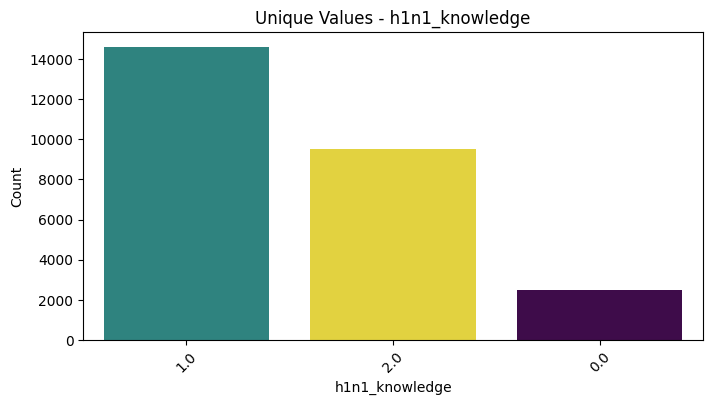

All unique values (3) are plotted for h1n1_knowledge.
Missing values in h1n1_knowledge: 116



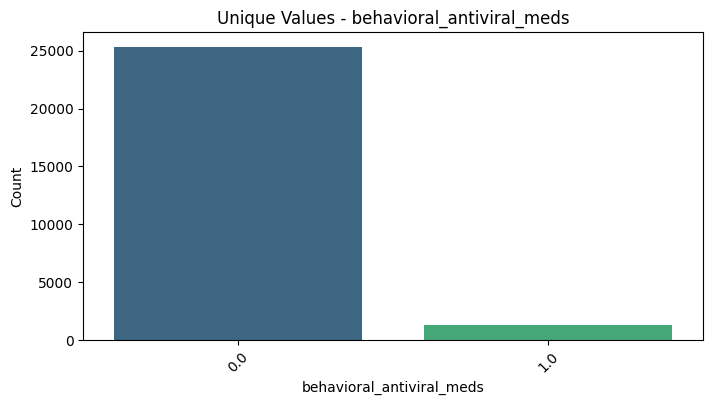

All unique values (2) are plotted for behavioral_antiviral_meds.
Missing values in behavioral_antiviral_meds: 71



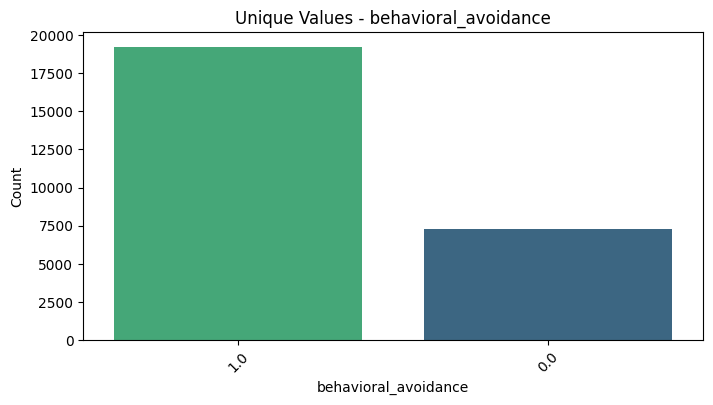

All unique values (2) are plotted for behavioral_avoidance.
Missing values in behavioral_avoidance: 208



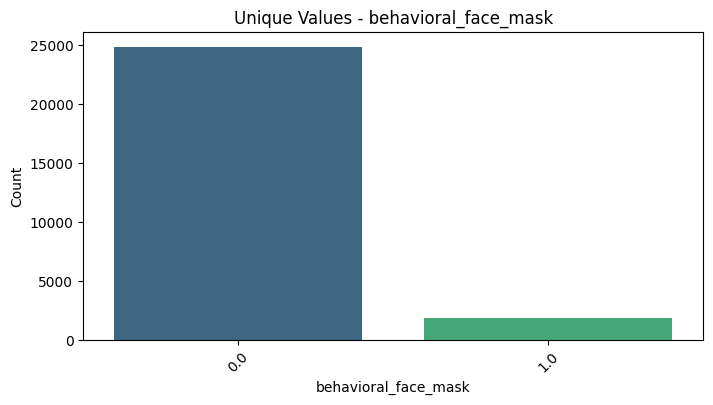

All unique values (2) are plotted for behavioral_face_mask.
Missing values in behavioral_face_mask: 19



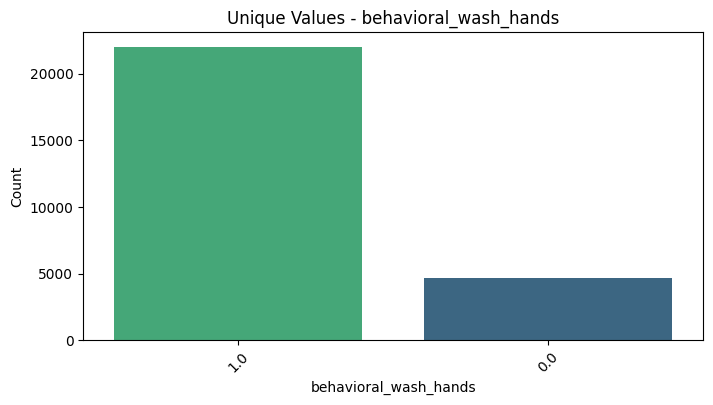

All unique values (2) are plotted for behavioral_wash_hands.
Missing values in behavioral_wash_hands: 42



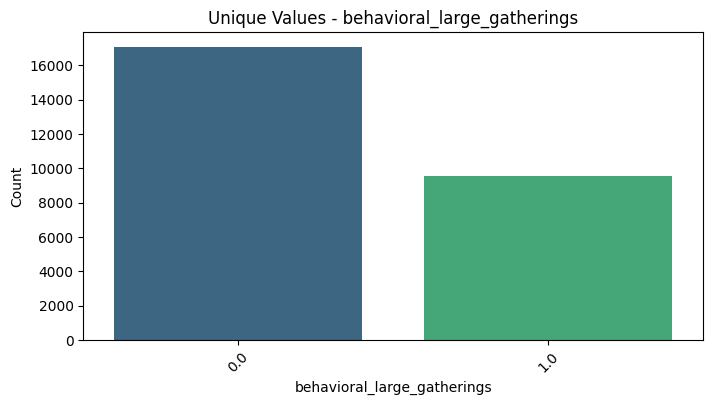

All unique values (2) are plotted for behavioral_large_gatherings.
Missing values in behavioral_large_gatherings: 87



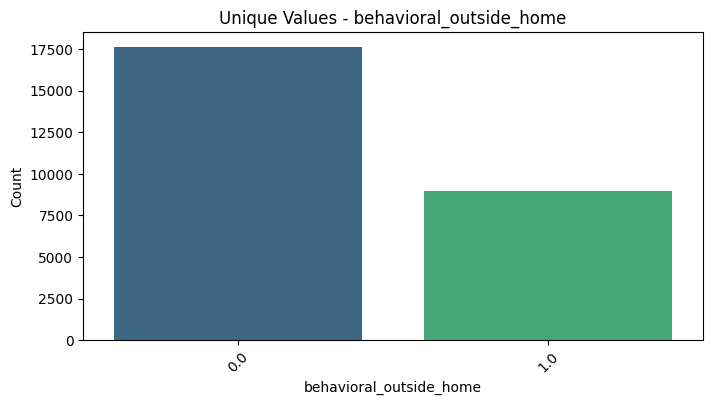

All unique values (2) are plotted for behavioral_outside_home.
Missing values in behavioral_outside_home: 82



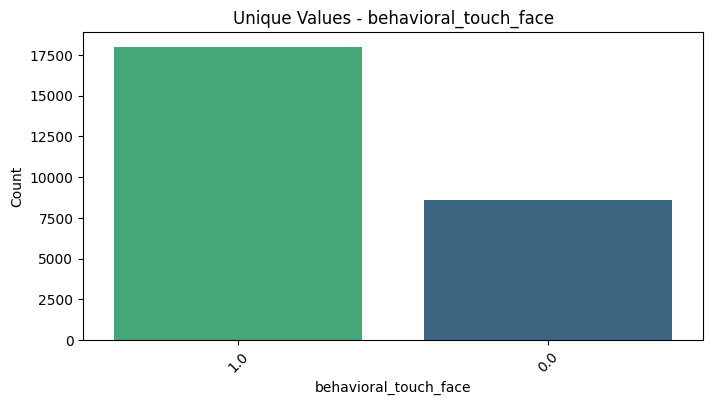

All unique values (2) are plotted for behavioral_touch_face.
Missing values in behavioral_touch_face: 128



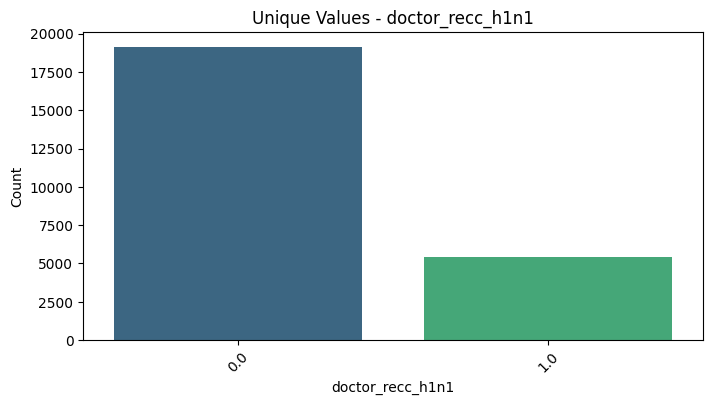

All unique values (2) are plotted for doctor_recc_h1n1.
Missing values in doctor_recc_h1n1: 2160



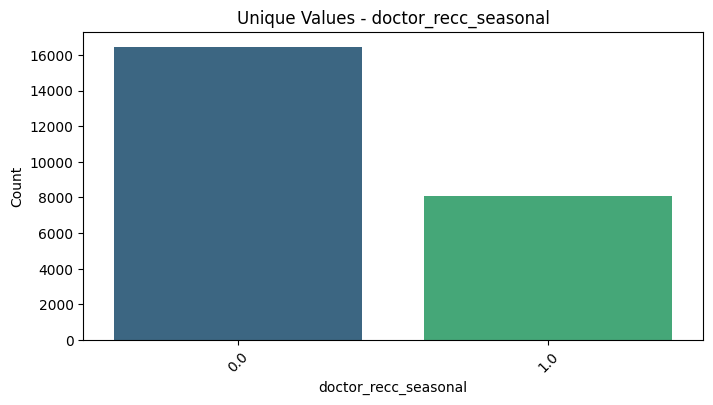

All unique values (2) are plotted for doctor_recc_seasonal.
Missing values in doctor_recc_seasonal: 2160



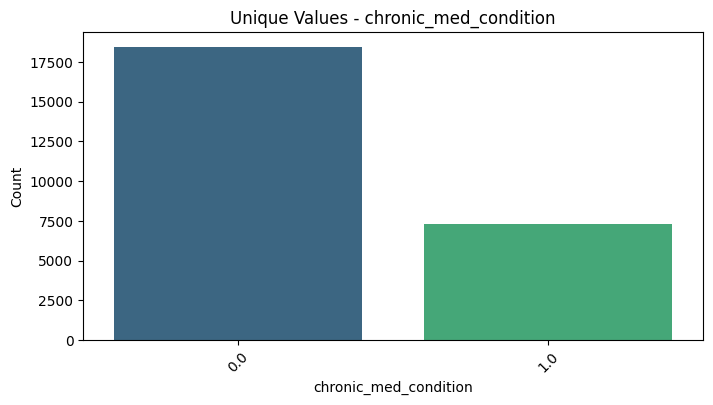

All unique values (2) are plotted for chronic_med_condition.
Missing values in chronic_med_condition: 971



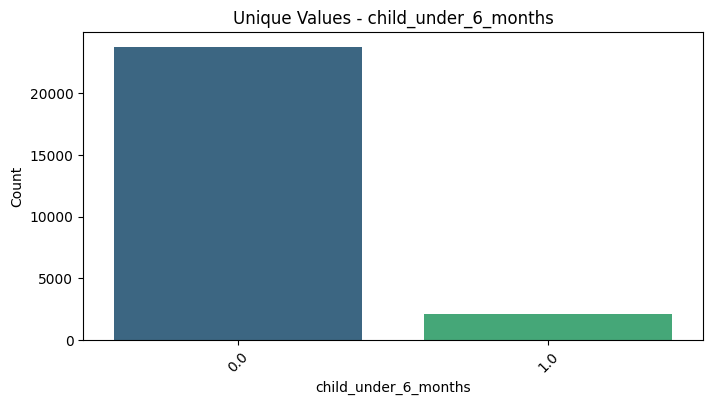

All unique values (2) are plotted for child_under_6_months.
Missing values in child_under_6_months: 820



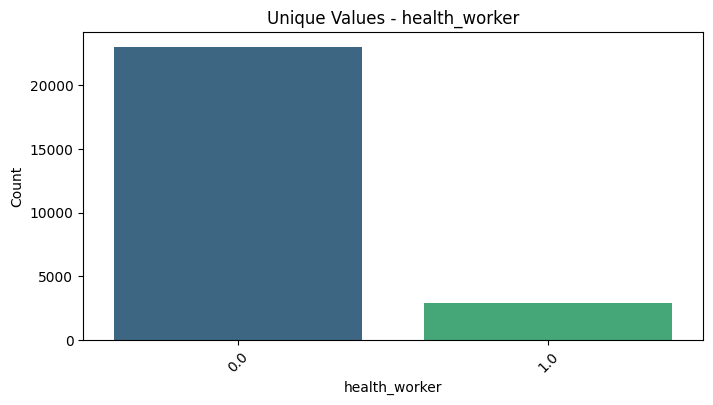

All unique values (2) are plotted for health_worker.
Missing values in health_worker: 804



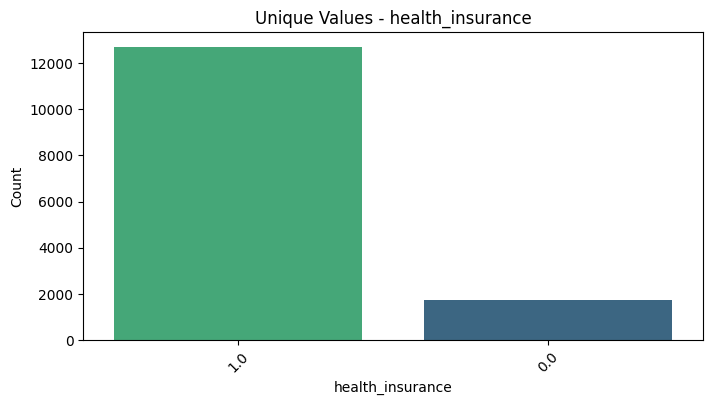

All unique values (2) are plotted for health_insurance.
Missing values in health_insurance: 12274



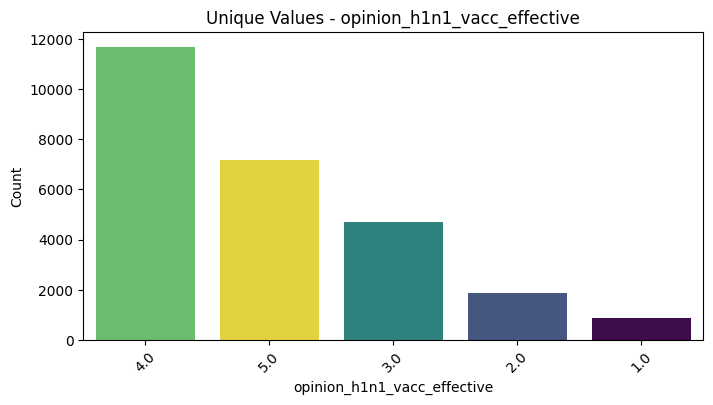

All unique values (5) are plotted for opinion_h1n1_vacc_effective.
Missing values in opinion_h1n1_vacc_effective: 391



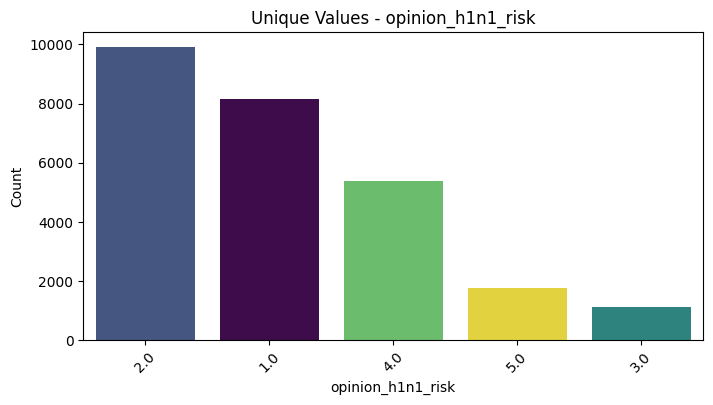

All unique values (5) are plotted for opinion_h1n1_risk.
Missing values in opinion_h1n1_risk: 388



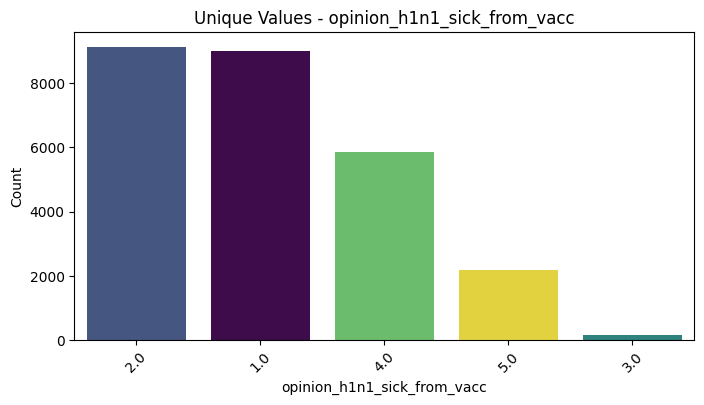

All unique values (5) are plotted for opinion_h1n1_sick_from_vacc.
Missing values in opinion_h1n1_sick_from_vacc: 395



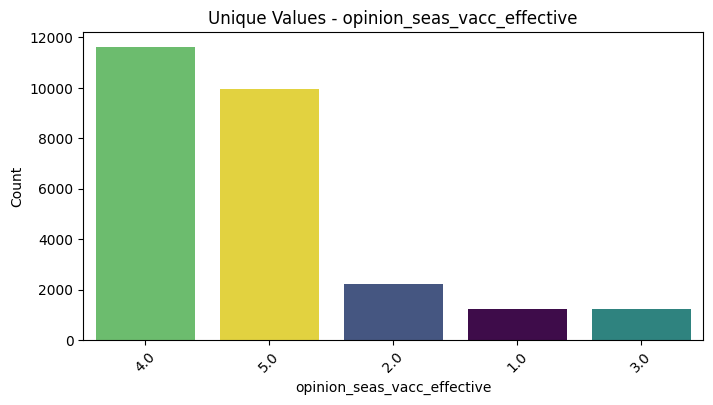

All unique values (5) are plotted for opinion_seas_vacc_effective.
Missing values in opinion_seas_vacc_effective: 462



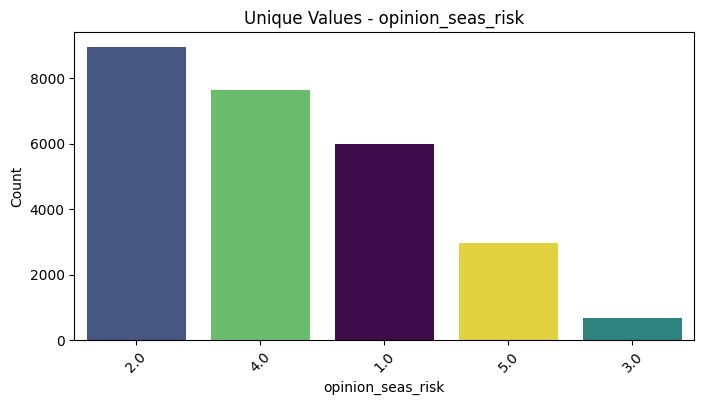

All unique values (5) are plotted for opinion_seas_risk.
Missing values in opinion_seas_risk: 514



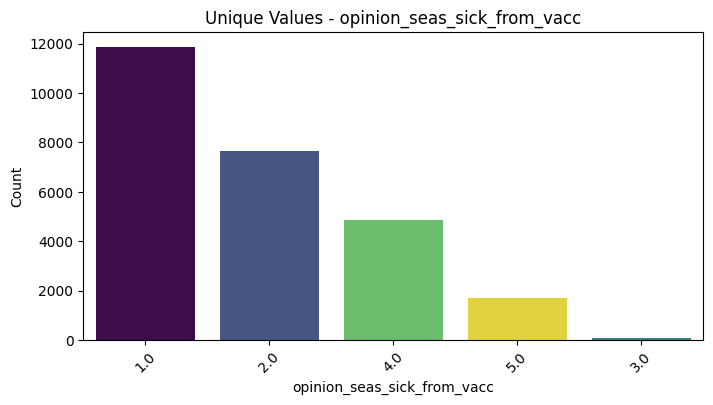

All unique values (5) are plotted for opinion_seas_sick_from_vacc.
Missing values in opinion_seas_sick_from_vacc: 537



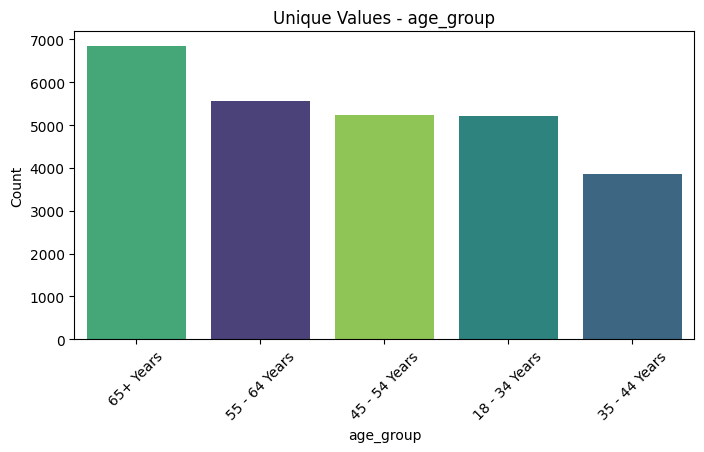

All unique values (5) are plotted for age_group.
Missing values in age_group: 0



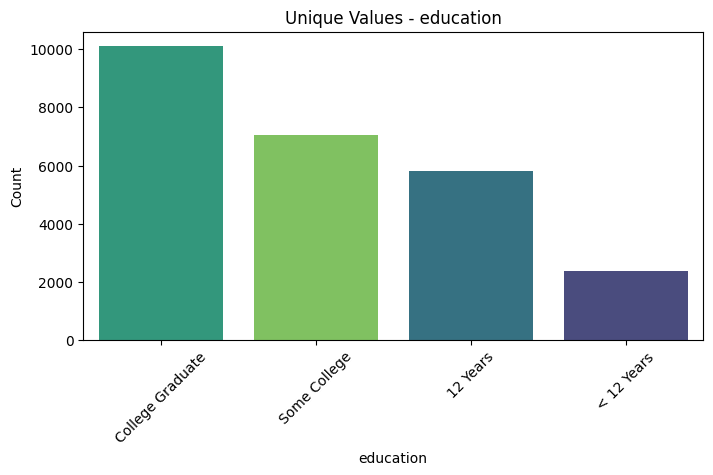

All unique values (4) are plotted for education.
Missing values in education: 1407



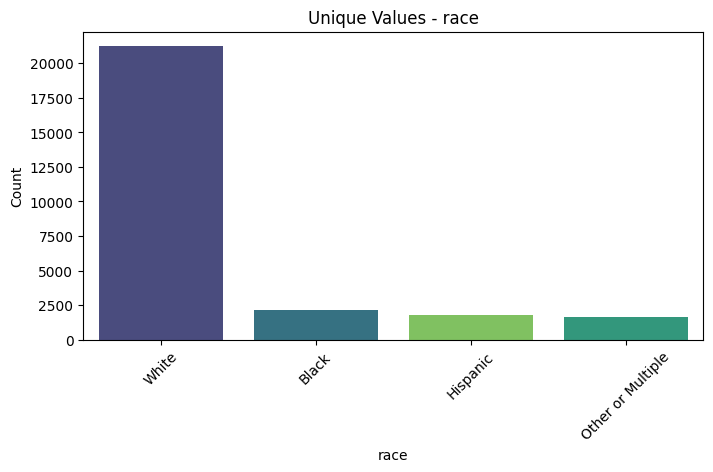

All unique values (4) are plotted for race.
Missing values in race: 0



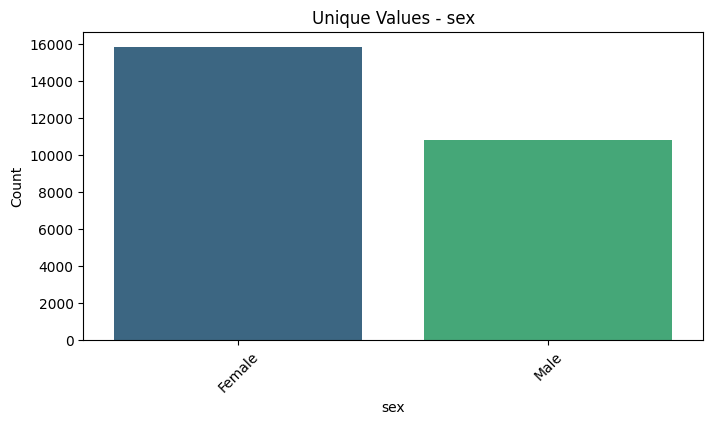

All unique values (2) are plotted for sex.
Missing values in sex: 0



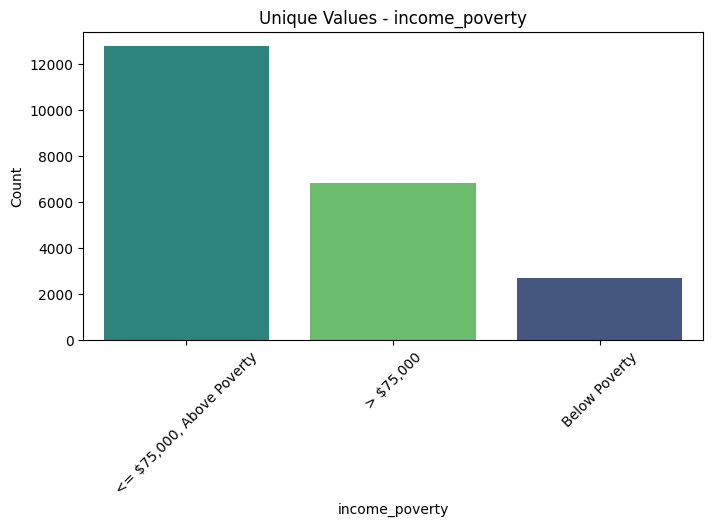

All unique values (3) are plotted for income_poverty.
Missing values in income_poverty: 4423



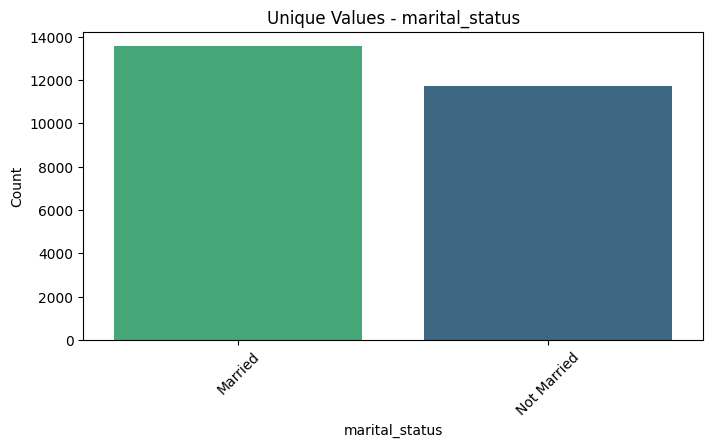

All unique values (2) are plotted for marital_status.
Missing values in marital_status: 1408



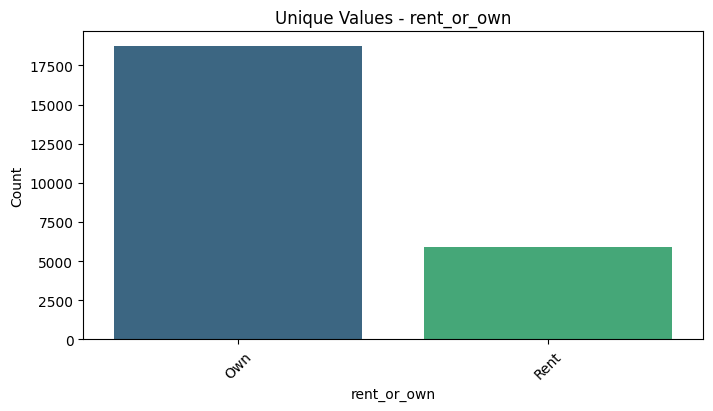

All unique values (2) are plotted for rent_or_own.
Missing values in rent_or_own: 2042



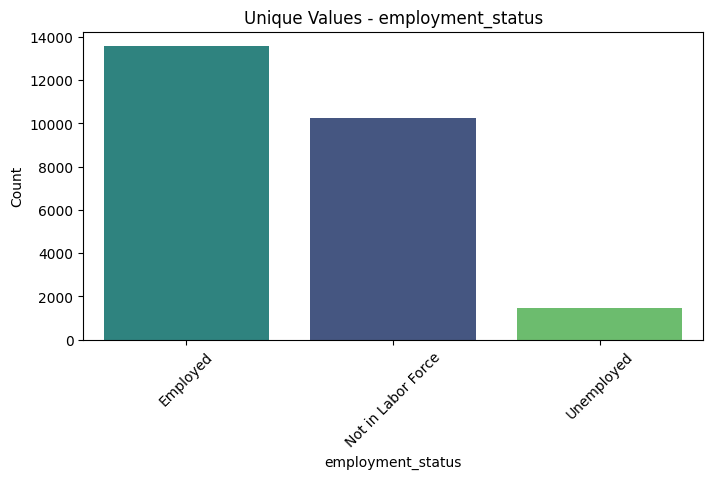

All unique values (3) are plotted for employment_status.
Missing values in employment_status: 1463



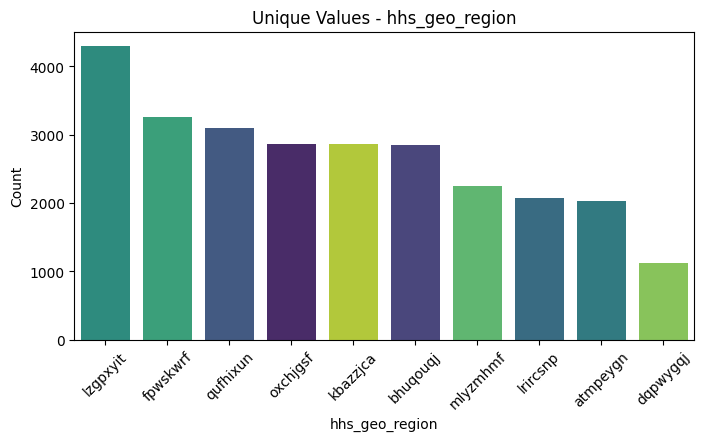

All unique values (10) are plotted for hhs_geo_region.
Missing values in hhs_geo_region: 0



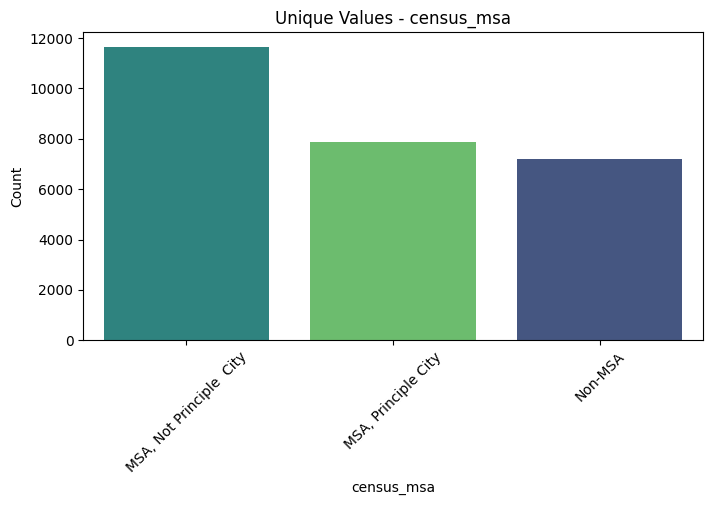

All unique values (3) are plotted for census_msa.
Missing values in census_msa: 0



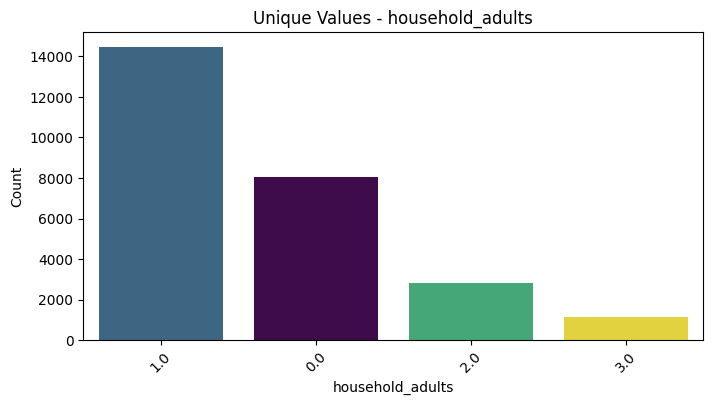

All unique values (4) are plotted for household_adults.
Missing values in household_adults: 249



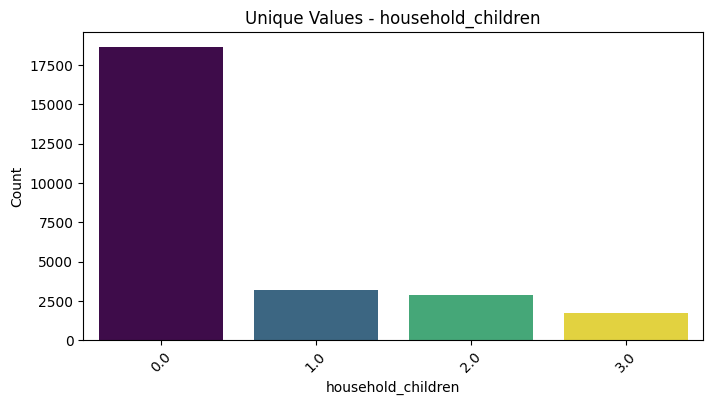

All unique values (4) are plotted for household_children.
Missing values in household_children: 249



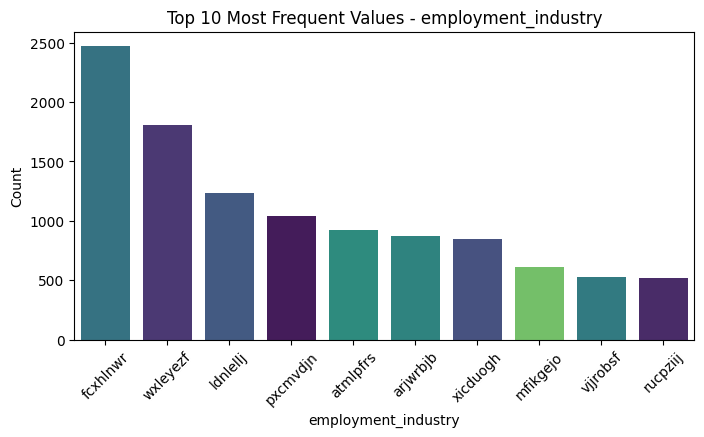

Only the top 10 most frequent values are plotted out of 21 unique values for employment_industry.
Missing values in employment_industry: 13330



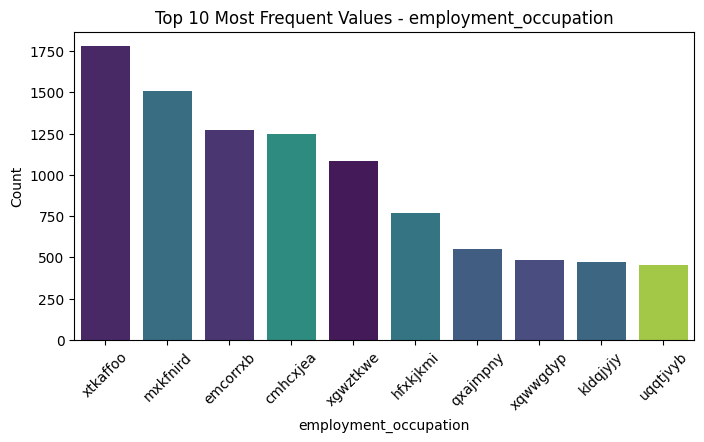

Only the top 10 most frequent values are plotted out of 23 unique values for employment_occupation.
Missing values in employment_occupation: 13470



In [117]:
plot_unique_values(X.drop('respondent_id', axis=1))

## Chi-Square Test

In [8]:
from scipy.stats import chi2_contingency

# Two Categorical Variables
def chi_square_test(series1, series2):
    # Create a contingency table from the two Series
    contingency_table = pd.crosstab(series1, series2)
    
    # Perform the chi-square test
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    
    return chi2

### Cramér's V, Phi coefficient, and Theil's U measures of association between the two categorical variables

In [9]:
from scipy.stats import chi2_contingency

def calculate_categorical_association(series1, series2, calculate_cramers_v=True, calculate_phi=True, calculate_theils_u=True):
    contingency_table = pd.crosstab(series1, series2)
    chi2, _, _, _ = chi2_contingency(contingency_table)
    num_records = len(series1)

    results = {}

    if calculate_cramers_v:
        cramers_v = np.sqrt(chi2 / (num_records * (min(contingency_table.shape)-1)))
        results['Cramér\'s V'] = cramers_v

    if calculate_phi and contingency_table.shape == (2, 2):
        phi_coefficient = np.sqrt(chi2 / num_records)
        results['Phi Coefficient'] = phi_coefficient

    if calculate_theils_u:
        entropy1 = series1.value_counts(normalize=True).apply(lambda x: x * np.log(x))
        entropy2 = series2.value_counts(normalize=True).apply(lambda x: x * np.log(x))
        conditional_entropy = (contingency_table / num_records).apply(lambda x: x * np.log(x))
        theils_u = (entropy1.sum() - conditional_entropy.sum().sum()) / entropy1.sum()
        results['Theil\'s U'] = theils_u

    return results

In [10]:
calculate_categorical_association(X.h1n1_concern, X.h1n1_knowledge)

{"Cramér's V": 0.12145346717987095, "Theil's U": -0.6928046766537673}

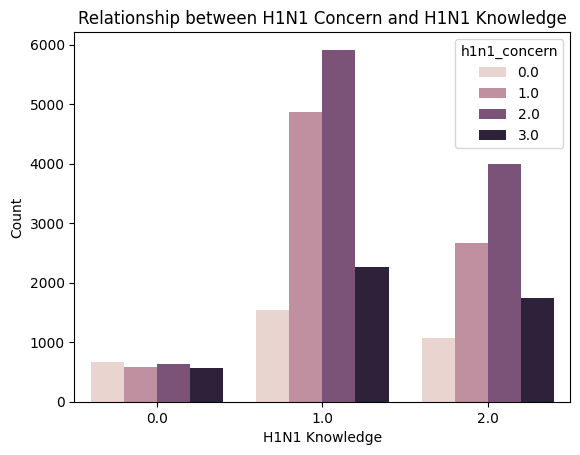

In [11]:
sns.countplot(x='h1n1_knowledge', hue='h1n1_concern', data=X)
plt.xlabel('H1N1 Knowledge')
plt.ylabel('Count')
plt.title('Relationship between H1N1 Concern and H1N1 Knowledge')
plt.show()

## Let's go through with A Simple Approch

### Create a Pipeline to Drop columns from a DataFrame based on a specified ratio threshold

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

class DropColumnsByRatio(BaseEstimator, TransformerMixin):
    def __init__(self, ratio):
        self.ratio = ratio
        self.columns_to_drop = []

    def fit(self, X, y=None):
        num_records = len(X)
        for column in X.columns:
            value_counts = X[column].value_counts()
            dominant_ratio = value_counts.iloc[0] / num_records
            if dominant_ratio >= self.ratio:
                self.columns_to_drop.append(column)
        return self

    def transform(self, X):
        return X.drop(columns=self.columns_to_drop)

In [13]:
dropColumns = DropColumnsByRatio(0.9)
_ = dropColumns.fit_transform(X)
print("The Columns have been droped: ", dropColumns.columns_to_drop)
_.head()

The Columns have been droped:  ['behavioral_antiviral_meds', 'behavioral_face_mask']


,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_avoidance,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


### Create a Pipeline Step to drop Specific Column

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

class DropColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        self.column_names = column_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X.drop(columns=self.column_names, inplace=True)
        return X

### Create a Pipeline Step to encode Specific Features with one-hot encoding and return the complete new dataframe

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder

class OneHotEncoderComplete(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        self.column_names = column_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Create an instance of the OneHotEncoder
        encoder = OneHotEncoder(sparse_output=False)

        # Fit and transform the selected features
        encoded_features = encoder.fit_transform(X[self.column_names])

        # Create a new dataframe with the encoded features
        encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(self.column_names))

        # Concatenate the encoded features with the remaining original features
        data_encoded = pd.concat([X.drop(columns=self.column_names), encoded_df], axis=1)
        return data_encoded

### Create a Pipeline to Impute Missing Values and return DataFrame

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class MySimpleImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='mean'):
        self.strategy = strategy
        self.imputer = SimpleImputer(strategy=self.strategy)

    def fit(self, X, y=None):
        self.imputer.fit(X)
        return self

    def transform(self, X):
        transformed_data = self.imputer.transform(X)
        transformed_df = pd.DataFrame(transformed_data, columns=X.columns)
        return transformed_df

### Custom Ordinal Encoder

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin

class OrdinalEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, mapping):
        self.mapping = mapping
        self.columns = list(self.mapping.keys())

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_encoded = X.copy()
        for column in self.columns:
            if self.mapping and column in self.mapping:
                X_encoded[column] = X[column].map(self.mapping[column])
        return X_encoded

## The Main Pipeline

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC


pipeline1 = Pipeline(
    steps=[
        ('drop_columns', DropColumnsTransformer(column_names=['respondent_id', 'behavioral_antiviral_meds', 'behavioral_face_mask', 'child_under_6_months', 'race', 
                                                            'employment_industry', 'employment_occupation', 'health_insurance', 'hhs_geo_region'])),
        ('impute_missing_values_with_most_freqent_mode', MySimpleImputer(strategy='most_frequent')),
        ('one_hot_encoder', OneHotEncoderComplete(column_names=['sex', 'marital_status', 'rent_or_own', 'employment_status', 'census_msa'])),
        ('ordinal_encoder', OrdinalEncoderTransformer(mapping={'age_group': {'55 - 64 Years': 4, '35 - 44 Years': 2,
                                                                            '18 - 34 Years': 1, '65+ Years': 5, '45 - 54 Years': 3},
                                                                'education': {'< 12 Years': 1, '12 Years': 2, 'Some College': 3, 'College Graduate': 4},
                                                                'income_poverty' :  {'Below Poverty' : 1, '<= $75,000, Above Poverty' : 2, '> $75,000' : 3}
                                                                }
                                                    )),
        ('convert_to_float', FunctionTransformer(lambda X: X.astype(float))),
        ('classifier', LogisticRegression(max_iter=1000))
    ]
)

### The Trainin Stage

In [19]:
from sklearn.metrics import make_scorer, precision_score, recall_score

def get_scores(model):
    # Define the scoring metrics you want to compute
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1': make_scorer(f1_score),
        'roc_auc': make_scorer(roc_auc_score)
    }
    # Perform cross-validation
    results = cross_validate(model, X, y.seasonal_vaccine, scoring=scoring, cv=5)  # cv=5 indicates 5-fold cross-validation

    # Print the scores for each metric
    for metric, scores in results.items():
        print(metric, ":", scores.mean())

In [20]:
get_scores(pipeline1)

fit_time : 0.573798656463623
score_time : 0.050606060028076175
test_accuracy : 0.7744413549289277
test_precision : 0.7725639730592657
test_recall : 0.7307599517490952
test_f1 : 0.7510484358486383
test_roc_auc : 0.7716302382033897


In [21]:
pipeline2 = Pipeline(
    steps=[
        ('drop_columns', DropColumnsTransformer(column_names=['respondent_id', 'race', 
                                                            'employment_industry', 'employment_occupation', 'hhs_geo_region'])),
        ('impute_missing_values_with_most_freqent_mode', MySimpleImputer(strategy='most_frequent')),
        ('one_hot_encoder', OneHotEncoderComplete(column_names=['sex', 'marital_status', 'rent_or_own', 'employment_status', 'census_msa', 'age_group', 'education', 'income_poverty'])),
        ('convert_to_float', FunctionTransformer(lambda X: X.astype(float))),
        ('classifier', LogisticRegression(max_iter=1000))
    ]
)

In [22]:
get_scores(pipeline2)

fit_time : 0.7828743934631348
score_time : 0.058824777603149414
test_accuracy : 0.7739171926503161
test_precision : 0.7692202396276654
test_recall : 0.7350221149979895
test_f1 : 0.7517021040792266
test_roc_auc : 0.7714140933953985


In [28]:
from catboost import CatBoostClassifier

pipeline3 = Pipeline(
    steps=[
        ('drop_columns', DropColumnsTransformer(column_names=['respondent_id', 'behavioral_antiviral_meds', 'behavioral_face_mask', 'child_under_6_months', 'race', 
                                                            'employment_industry', 'employment_occupation', 'health_insurance', 'hhs_geo_region'])),
        ('impute_missing_values_with_most_freqent_mode', MySimpleImputer(strategy='most_frequent')),
        ('one_hot_encoder', OneHotEncoderComplete(column_names=['sex', 'marital_status', 'rent_or_own', 'employment_status', 'census_msa'])),
        ('ordinal_encoder', OrdinalEncoderTransformer(mapping={'age_group': {'55 - 64 Years': 4, '35 - 44 Years': 2,
                                                                            '18 - 34 Years': 1, '65+ Years': 5, '45 - 54 Years': 3},
                                                                'education': {'< 12 Years': 1, '12 Years': 2, 'Some College': 3, 'College Graduate': 4},
                                                                'income_poverty' :  {'Below Poverty' : 1, '<= $75,000, Above Poverty' : 2, '> $75,000' : 3}
                                                                }
                                                    )),
        ('convert_to_float', FunctionTransformer(lambda X: X.astype(float))),
        ('classifier', CatBoostClassifier(iterations=100, depth=2, learning_rate=0.01, loss_function='Logloss', verbose=True))
    ]
)

In [29]:
get_scores(pipeline3)

0:	learn: 0.6904600	total: 6.42ms	remaining: 635ms
1:	learn: 0.6878273	total: 13.8ms	remaining: 678ms
2:	learn: 0.6853406	total: 21.9ms	remaining: 709ms
3:	learn: 0.6829686	total: 27.2ms	remaining: 654ms
4:	learn: 0.6804701	total: 32.2ms	remaining: 611ms
5:	learn: 0.6781840	total: 38.4ms	remaining: 601ms
6:	learn: 0.6757728	total: 44.7ms	remaining: 594ms
7:	learn: 0.6734162	total: 50.3ms	remaining: 579ms
8:	learn: 0.6711947	total: 55.2ms	remaining: 559ms
9:	learn: 0.6689241	total: 59.9ms	remaining: 539ms
10:	learn: 0.6667793	total: 64.2ms	remaining: 519ms
11:	learn: 0.6645882	total: 69.5ms	remaining: 510ms
12:	learn: 0.6625240	total: 74.9ms	remaining: 502ms
13:	learn: 0.6604147	total: 78.9ms	remaining: 485ms
14:	learn: 0.6584930	total: 83.3ms	remaining: 472ms
15:	learn: 0.6564646	total: 88.8ms	remaining: 466ms
16:	learn: 0.6544713	total: 92.8ms	remaining: 453ms
17:	learn: 0.6525252	total: 96.7ms	remaining: 441ms
18:	learn: 0.6507351	total: 102ms	remaining: 436ms
19:	learn: 0.6488550	to

In [33]:
pipeline4 = Pipeline(
    steps=[
        ('drop_columns', DropColumnsTransformer(column_names=['respondent_id', 'behavioral_antiviral_meds', 'behavioral_face_mask', 'child_under_6_months', 'race', 
                                                            'employment_industry', 'employment_occupation', 'health_insurance', 'hhs_geo_region'])),
        ('impute_missing_values_with_most_freqent_mode', MySimpleImputer(strategy='most_frequent')),
        ('one_hot_encoder', OneHotEncoderComplete(column_names=['sex', 'marital_status', 'rent_or_own', 'employment_status', 'census_msa'])),
        ('ordinal_encoder', OrdinalEncoderTransformer(mapping={'age_group': {'55 - 64 Years': 4, '35 - 44 Years': 2,
                                                                            '18 - 34 Years': 1, '65+ Years': 5, '45 - 54 Years': 3},
                                                                'education': {'< 12 Years': 1, '12 Years': 2, 'Some College': 3, 'College Graduate': 4},
                                                                'income_poverty' :  {'Below Poverty' : 1, '<= $75,000, Above Poverty' : 2, '> $75,000' : 3}
                                                                }
                                                    )),
        ('convert_to_float', FunctionTransformer(lambda X: X.astype(float))),
        ('classifier', XGBClassifier(colsample_bytree=0.6, 
                             learning_rate=0.01,
                             max_depth=5,
                             n_estimators=1000,
                             subsample=0.3))
    ]
)

In [34]:
get_scores(pipeline4)

fit_time : 2.8810267448425293
score_time : 0.14062418937683105
test_accuracy : 0.7832403639722971
test_precision : 0.7759280446054942
test_recall : 0.7515882589465219
test_f1 : 0.7635386339010033
test_roc_auc : 0.7812034299665006
